In [ ]:
# Clone the dataset repository
!git clone https://github.com/nisrinv/final_data.git

fatal: destination path 'final_data' already exists and is not an empty directory.


In [ ]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Load and Preprocess Images

---

using grayscale

In [ ]:
# Function to load images from a specified folder, resize them, and store in an array
def load_images_from_folder(folder, img_size):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        # Load image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Image {img_path} could not be loaded.")
            continue
        # Resize image to specified size
        img = cv2.resize(img, (img_size, img_size))
        images.append(img)
        # Extract label from filename (assuming filename contains the label)
        label = filename.split(' ')[0]  # Adjust this line based on your naming convention
        labels.append(label)
    return np.array(images), np.array(labels)

# Set the image size (width x height)
img_size = 64  # Resize images to 64x64

# Load training images and labels from the 'train/images' folder
X_train, y_train = load_images_from_folder('/content/final_data/train/images', img_size)

# Load testing images and labels from the 'test/images' folder
X_test, y_test = load_images_from_folder('/content/final_data/test/images', img_size)

## Flatten images for SVM
SVM requires a 1D feature vector, so need to flatten the 2D images into 1D arrays.

---



In [ ]:
# Flatten the images from 2D (64x64) to 1D (4096) for SVM processing
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

 initializes the SVM model and trains it using the flattened training data.

In [ ]:
# Initialize the SVM model
svm = SVC(kernel='linear')  # You can try different kernels like 'rbf', 'poly', etc.

# Train the SVM model using the training data
svm.fit(X_train_flattened, y_train)


SVC(kernel='linear')

## Model Evaluation

---

In [ ]:
# Predict the labels for the test set
y_pred = svm.predict(X_test_flattened)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print a detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.97
                precision    recall  f1-score   support

             1       1.00      0.45      0.62        20
            10       1.00      1.00      1.00        20
             2       0.65      1.00      0.78        20
             3       1.00      1.00      1.00        20
             4       1.00      1.00      1.00        20
             5       1.00      1.00      1.00        20
             6       1.00      1.00      1.00        20
             7       1.00      1.00      1.00        20
             8       1.00      1.00      1.00        20
             9       1.00      1.00      1.00        20
             A       1.00      1.00      1.00        20
           Air       1.00      1.00      1.00        20
         Angsa       1.00      1.00      1.00        20
             B       1.00      0.65      0.79        20
    BadakSumbu       1.00      1.00      1.00        20
          Baju       1.00      1.00      1.00        20
         Betul       1.00      1

Confusion Matrix

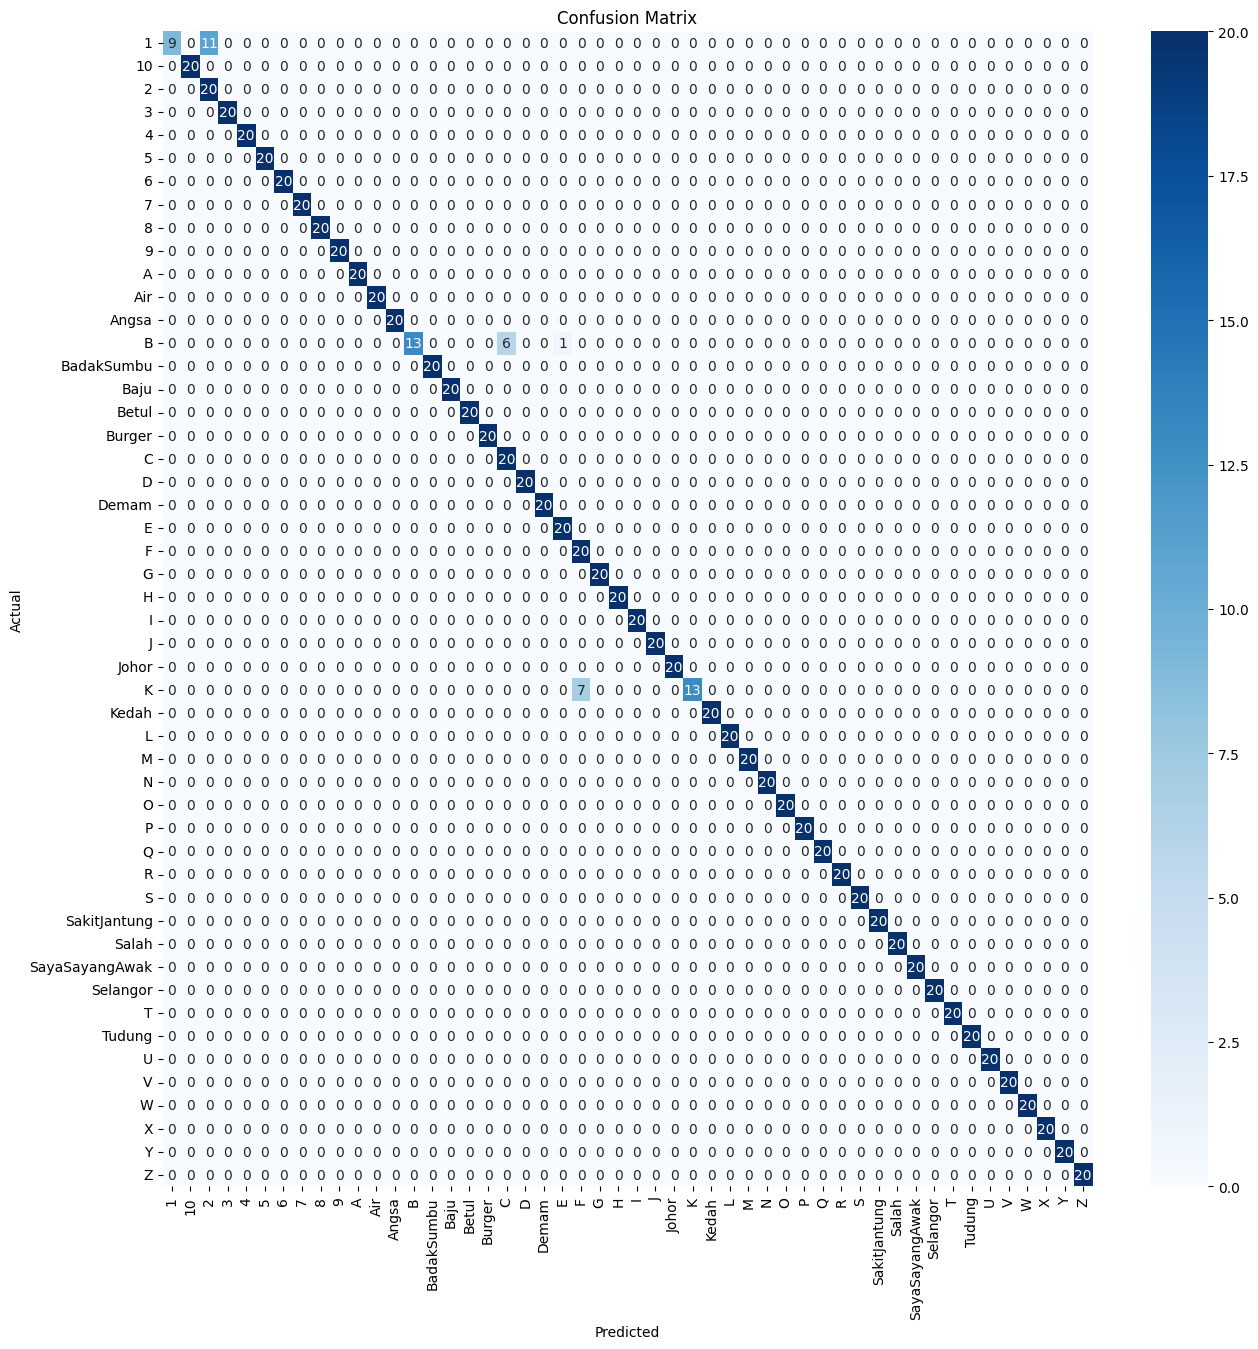

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# List of unique class labels in the order they appear in y_test/y_pred
class_labels = np.unique(y_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# Plotting the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Check hyperparameters
svm_params = svm.get_params()
print("SVM Hyperparameters:")
for param, value in svm_params.items():
    print(f"{param}: {value}")

SVM Hyperparameters:
C: 1.0
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: linear
max_iter: -1
probability: False
random_state: None
shrinking: True
tol: 0.001
verbose: False


In [ ]:
# Check learned parameters (for linear kernel)
if svm.kernel == 'linear':
    print("SVM Coefficients (weights):")
    print(svm.coef_)
    print("SVM Intercept:")
    print(svm.intercept_)
else:
    print("SVM parameters like coef_ and intercept_ are not available for non-linear kernels.")

SVM Coefficients (weights):
[[-1.08505573e-05 -1.07086285e-05 -1.08514012e-05 ... -3.87863520e-06
  -4.38246070e-06 -4.79436206e-06]
 [ 2.11652788e-05  2.28435290e-05  1.93070849e-05 ... -4.65758605e-06
  -3.18017747e-06 -3.01255332e-06]
 [ 1.17771474e-05  1.27698317e-05  1.07988995e-05 ... -8.26382987e-06
  -8.83140883e-06 -9.06506270e-06]
 ...
 [ 6.62566879e-07  7.73287082e-07  6.87715562e-07 ...  2.26820555e-05
   2.69577434e-05  2.35570450e-06]
 [-2.74275687e-07 -2.96860465e-07 -1.61278209e-07 ...  2.88927788e-06
   1.55083315e-05 -2.81422281e-06]
 [-4.81179694e-07 -5.40738874e-07 -3.35691781e-07 ... -1.37067718e-05
  -6.86192700e-06 -3.12551283e-06]]
SVM Intercept:
[-0.59536862  0.43809781  2.2896455  ...  0.47061895  0.78808519
 -0.31063911]


## Real Time Detection

---



In [ ]:
# Function to predict a new image using the trained SVM model
def predict_image(img_path, model, img_size):
    # Load and preprocess the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at path '{img_path}' could not be loaded. Please check the file path.")
    img = cv2.resize(img, (img_size, img_size))
    img_flattened = img.flatten().reshape(1, -1)
    # Predict the class of the image
    return model.predict(img_flattened)

# Example usage of predict_image function
# Replace 'path_to_new_image.jpg' with the path to the image you want to predict
try:
    prediction = predict_image('/content/final_data/test/images/9 (93).jpg', svm, img_size)
    print(f"Predicted Sign Language: {prediction[0]}")
except ValueError as e:
    print(e)

Predicted Sign Language: 9
